In [2]:
import os
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt

In [3]:
def load_dataset(path):
    return pd.read_csv(path, header=0)

def correlation(dataset):
    fig = plt.figure(figsize=(8, 5))
    corr = dataset.corr()

    ax = fig.add_subplot(111)
    cax = ax.matshow(corr, cmap="RdBu_r", vmin=-1, vmax=1)
    fig.colorbar(cax)
    plt.xticks(range(len(corr.columns)), corr.columns, fontsize=10, rotation=45, ha='left')
    plt.yticks(range(len(corr.columns)), corr.columns, fontsize=10)
    plt.title('Correlation Matrix', fontsize=15)
    plt.show()

    
def split_dataset(dataset, labels_colname, test_size=0.25):
    global seed
    # Create features and labels 
    features = dataset.drop([labels_colname], axis=1)
    labels = dataset[labels_colname]
    
    # Create training and test set 
    from sklearn.model_selection import train_test_split
    features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=test_size, random_state=seed)
    
    return features_train, features_test, labels_train, labels_test


def scaling(features_train, features_test, scaler="s"):
    # Minmax Normalisation
    if scaler == "m":
        from sklearn.preprocessing import MinMaxScaler 
        minMaxScaler = MinMaxScaler()
        features_train_scaled = minMaxScaler.fit_transform(features_train) 
        features_test_scaled = minMaxScaler.transform(features_test)
    
    # Standardisation
    elif scaler == "s":
        from sklearn.preprocessing import StandardScaler
        standardScaler = StandardScaler()
        features_train_scaled = standardScaler.fit_transform(features_train) 
        features_test_scaled = standardScaler.transform(features_test)
   
    return features_train_scaled, features_test_scaled
    
def imputation(dataset, columns, miss_value, imputer="median"):
    from sklearn.impute import SimpleImputer
    
    # imputation with median strategy
    if imputer == "median":
        im = SimpleImputer(missing_values = miss_value, strategy = 'median')
        dataset_imputed = im.fit_transform(dataset[columns]) # ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
        dataset[columns] = dataset_imputed
    
    # imputation with mean strategy
    elif imputer == "mean":
        im = SimpleImputer(missing_values = miss_value, strategy = 'mean')
        dataset_imputed = im.fit_transform(dataset[columns])
        dataset[columns] = dataset_imputed
    
    return dataset

def rebalance(features_train,labels_train, labels_colname, resampling="up"):
    global seed
    df = pd.concat([features_train,labels_train],axis=1)
    # Separate majority and minority classes
    df_majority = df[df[labels_colname]==0] 
    df_minority = df[df[labels_colname]==1]
    major_samples = len(df_majority)
    minor_samples = len(df_minority)
    from sklearn.utils import resample
    
    if resampling == "up":
        # Upsample samples with replacement for minority class
        df_minority_upsampled = resample(df_minority,
                                         replace=True, # sample with replacement
                                         n_samples=major_samples, # to match majority class
                                         random_state=seed) # reproducible results
        df_upsampled = pd.concat([df_majority, df_minority_upsampled])
        # re-preparing the training sets
        features_train = df_upsampled.drop([labels_colname], axis=1)
        labels_train = df_upsampled[[labels_colname]]
    
    elif resampling == "down":
        # Upsample samples without replacement for minority class
        df_majority_downsampled = resample(df_majority,
                                           replace=False, # sample without replacement
                                           n_samples=minor_samples, # to match minority class
                                           random_state=seed) # reproducible results
        df_downsampled = pd.concat([df_majority_downsampled, df_minority])
        # re-preparing the training sets
        features_train = df_downsampled.drop([labels_colname], axis=1)
        labels_train = df_downsampled[[labels_colname]]
    
    return features_train,labels_train


def display_metrics(labels_test, pred):
    #Check accuracy
    from sklearn.metrics import accuracy_score
    accuracy = accuracy_score(labels_test, pred)
    print('Accuracy: {:.2f}'.format(accuracy))
    
    #Check precision
    from sklearn.metrics import precision_score
    precision = precision_score(labels_test, pred)
    print ('Precision: {:.2f}'.format(precision))

    # Check recall
    from sklearn.metrics import recall_score
    recall = recall_score(labels_test, pred)
    print ('Recall: {:.2f}'.format(recall))

    # Check F1 score
    from sklearn.metrics import f1_score
    f1 = f1_score(labels_test, pred)
    print ('F1 score: {:.2f}'.format(f1))

    # Check with AUROC
    from sklearn.metrics import roc_auc_score
    auroc = roc_auc_score(labels_test, pred)
    print ('AUROC score: {:.2f}'.format(auroc))
    return accuracy, precision, recall, f1, auroc


def plot_roc_curve(labels_test, pred):
    from sklearn.metrics import roc_curve
    fpr, tpr, thresholds = roc_curve(labels_test, pred)
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

def models_boxplot(features_train, labels_train, models, scoring):
    results = []
    names = []
    
    from sklearn import model_selection
    for name, model in models:
        kfold = model_selection.KFold(n_splits=10)
        cv_results = model_selection.cross_val_score(model, features_train,labels_train, cv=kfold, scoring=scoring)
        results.append(cv_results)
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)
    # boxplot algorithm comparison
    fig = plt.figure()
    fig.suptitle(f'Algorithm Comparison\n(score={scoring})')
    ax = fig.add_subplot(111)
    plt.boxplot(results)
    ax.set_xticklabels(names)
    plt.show()

Data exploration

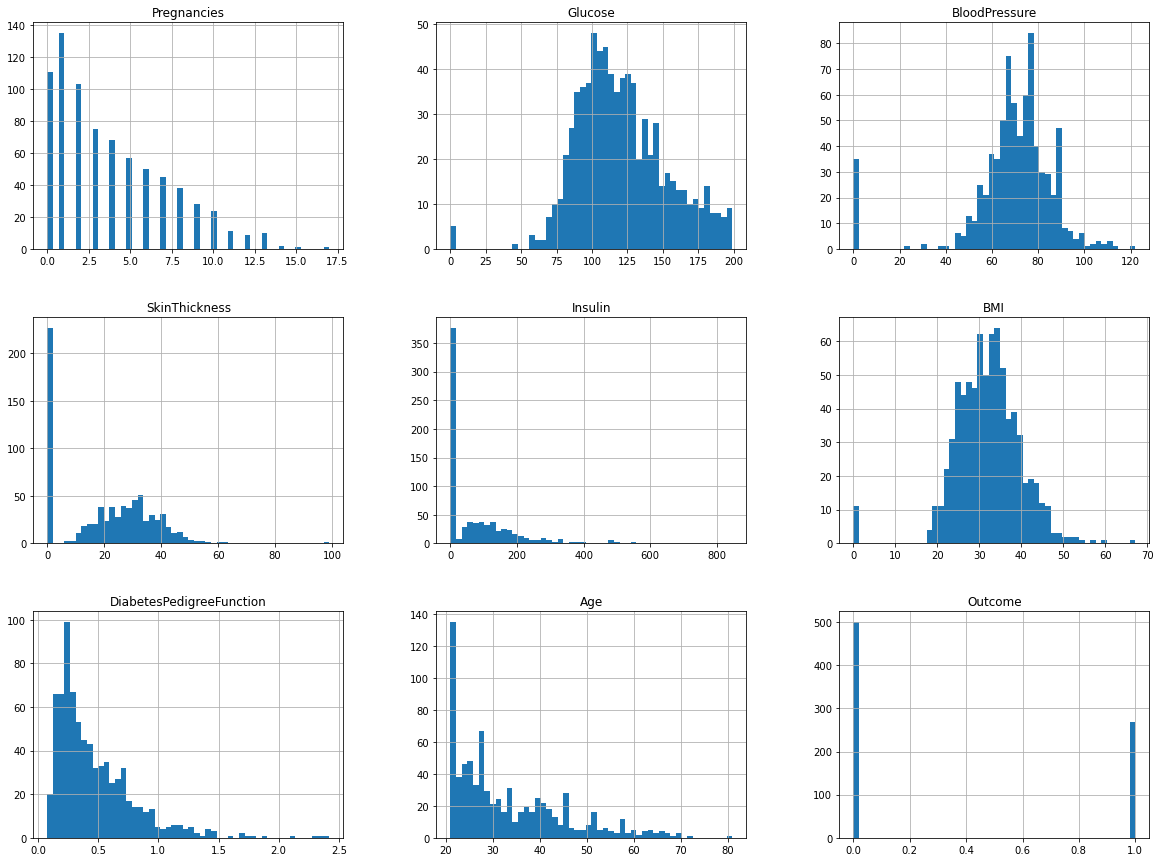

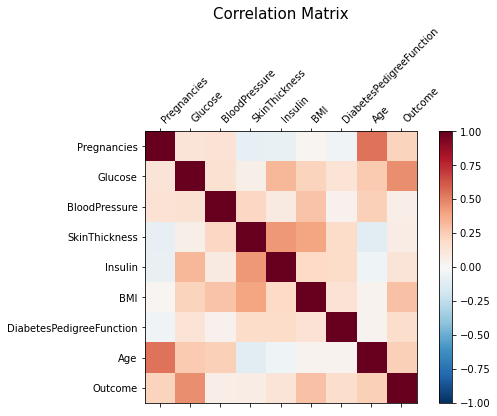

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [4]:
seed = 123
path = "diabetes.csv"

dataset = load_dataset(path)
dataset.hist(bins=50, figsize = (20,15))
correlation(dataset)
plt.show()
dataset.head()

Data preprocessing

In [5]:
columns = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
dataset = imputation(dataset, columns, 0, imputer="median")
features_train, features_test, labels_train, labels_test = split_dataset(dataset, 'Outcome', test_size=0.25)
features_train,labels_train = rebalance(features_train ,labels_train, 'Outcome', resampling="up")
features_train_scaled, features_test_scaled = scaling(features_train, features_test, scaler="s")

# 1st

Accuracy: 0.76
Precision: 0.63
Recall: 0.88
F1 score: 0.74
AUROC score: 0.78


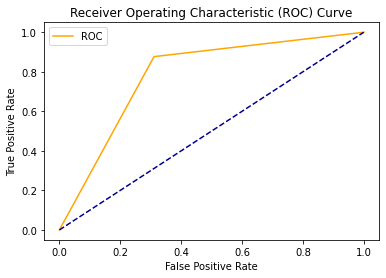

In [6]:
# building model
# kNN
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(features_train_scaled, labels_train)
knn_pred = knn.predict(features_test_scaled)
accuracy, precision, recall, f1, auroc = display_metrics(labels_test, knn_pred)
plot_roc_curve(labels_test, knn_pred)

Accuracy: 0.78
Precision: 0.68
Recall: 0.81
F1 score: 0.74
AUROC score: 0.79


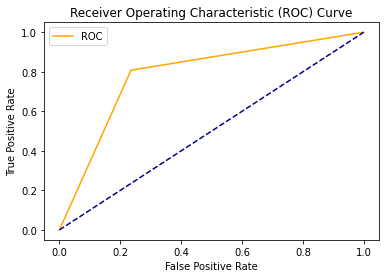

In [7]:
# building model
# SVM
from sklearn.svm import SVC
svm = SVC(gamma='auto')
svm.fit(features_train_scaled, labels_train)
svm_pred = svm.predict(features_test_scaled)
accuracy, precision, recall, f1, auroc = display_metrics(labels_test, svm_pred)
plot_roc_curve(labels_test, svm_pred)

Accuracy: 0.76
Precision: 0.67
Recall: 0.73
F1 score: 0.70
AUROC score: 0.75


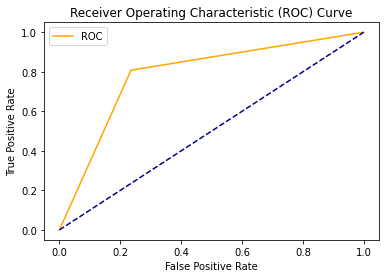

In [8]:
# building model
# LR
from sklearn.linear_model import LogisticRegression 
lg = LogisticRegression(C=1.0)
lg.fit(features_train_scaled, labels_train)
lg_pred = lg.predict(features_test_scaled)
accuracy, precision, recall, f1, auroc = display_metrics(labels_test, lg_pred)
plot_roc_curve(labels_test, svm_pred)

SVM is the most suitable for diabetes dataset, we optimize it in the following steps.

In [81]:
from sklearn.model_selection import GridSearchCV
params={'kernel' : ['rbf','linear','sigmoid'],
        'gamma' : [0.1, 1, 10, 100],
        'degree' : [0, 1, 2, 3, 4, 5],
        'C' : [0.01, 0.1, 1, 10, 100]}
gs=GridSearchCV(svm, params, verbose=False, n_jobs=-1, cv=10)
gs_results=gs.fit(features_train_scaled, labels_train)
print(f"Best score: {gs_results.best_score_}\nBest parameters: {gs_results.best_params_}")

Best score: 0.9278708133971293
Best parameters: {'C': 1, 'degree': 0, 'gamma': 100, 'kernel': 'rbf'}


# 2rd

KNN: 0.743199 (0.098628)
SVM: 0.739012 (0.044900)
LR: 0.698291 (0.037801)


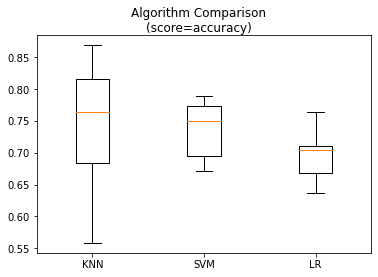

In [65]:
models_boxplot(features_train_scaled,labels_train, 
               models=[('KNN', KNeighborsClassifier()),
                       ('SVM', SVC()),
                       ('LR', LogisticRegression())], 
               scoring='accuracy')

KNN has higher accurarcy in average, however, it has too large standard deviation. SVM is more suitable for diabetes dataset, we optimize it in the following steps.

In [82]:
from sklearn.model_selection import GridSearchCV
params={'kernel' : ['rbf','linear','sigmoid'],
        'gamma' : [0.1, 1, 10, 100],
        'degree' : [0, 1, 2, 3, 4, 5],
        'C' : [0.01, 0.1, 1, 10, 100]}
gs=GridSearchCV(svm, params, verbose=False, n_jobs=-1, cv=10)
gs_results=gs.fit(features_train_scaled, labels_train)
print(f"Best score: {gs_results.best_score_}\nBest parameters: {gs_results.best_params_}")

Best score: 0.9278708133971293
Best parameters: {'C': 1, 'degree': 0, 'gamma': 100, 'kernel': 'rbf'}


# 3rd (or 4th?)

In [10]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score, precision_score, recall_score

models = {
    'KNN': KNeighborsClassifier(),
    'LogisticRegression': LogisticRegression(),
    'SVM': SVC()
}

params={'KNN': {'selectkbest__k':[1,2,3,4,5,6],
                'kneighborsclassifier__n_neighbors' : [3,5,7,9,11,13,15],
                'kneighborsclassifier__weights' : ['uniform', 'distance'],
                'kneighborsclassifier__metric' : ['euclidian','manhattan']
                                 },
        'LogisticRegression': {'selectkbest__k':[1,2,3,4,5,6],
                               'logisticregression__C' : [0.01, 0.1, 1, 10, 100],
                               'logisticregression__penalty' : ['l1','l2','elastic-net','None'],
                               'logisticregression__solver' : ['liblinear','newton-cg','lbfgs','sag','saga']
                              },
        'SVM': {'selectkbest__k':[1,2,3,4,5,6],
                'svc__kernel' : ['rbf','linear','sigmoid'],
                'svc__gamma' : [0.1, 1, 10, 100],
                'svc__degree' : [0, 1, 2, 3, 4, 5],
                'svc__C' : [0.01, 0.1, 1, 10, 100]}
       }

for name in models.keys():
    est = models[name]
    est_params = params[name]
    pipe = make_pipeline(StandardScaler(),SelectKBest(f_regression) ,est)
    gs = GridSearchCV(pipe, param_grid=est_params, verbose=False, n_jobs=-1, cv=10)
    gs.fit(features_train, labels_train)
    print(f"------{name}------")
    print(f"Best score: {gs.best_score_}")
    print(f"Best parameters are: {gs.best_params_}")
    

------KNN------
Best score: 0.8518455228981544
Best parameters are: {'kneighborsclassifier__metric': 'manhattan', 'kneighborsclassifier__n_neighbors': 13, 'kneighborsclassifier__weights': 'distance', 'selectkbest__k': 3}
------LogisticRegression------
Best score: 0.7586466165413535
Best parameters are: {'logisticregression__C': 0.01, 'logisticregression__penalty': 'l2', 'logisticregression__solver': 'liblinear', 'selectkbest__k': 3}
------SVM------
Best score: 0.9278879015721122
Best parameters are: {'selectkbest__k': 6, 'svc__C': 1, 'svc__degree': 0, 'svc__gamma': 10, 'svc__kernel': 'rbf'}


In [12]:
pd.DataFrame(gs.cv_results_).sort_values(by='rank_test_score').head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_selectkbest__k,param_svc__C,param_svc__degree,param_svc__gamma,param_svc__kernel,params,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
2010,0.132739,0.063981,0.014901,0.000550,6,1,5,10,rbf,"{'selectkbest__k': 6, 'svc__C': 1, 'svc__degre...",...,0.934211,0.934211,0.907895,0.973684,0.907895,0.921053,0.947368,0.927888,0.024126,1
1986,0.146095,0.045140,0.016119,0.001499,6,1,3,10,rbf,"{'selectkbest__k': 6, 'svc__C': 1, 'svc__degre...",...,0.934211,0.934211,0.907895,0.973684,0.907895,0.921053,0.947368,0.927888,0.024126,1
1998,0.116303,0.031475,0.015803,0.001248,6,1,4,10,rbf,"{'selectkbest__k': 6, 'svc__C': 1, 'svc__degre...",...,0.934211,0.934211,0.907895,0.973684,0.907895,0.921053,0.947368,0.927888,0.024126,1
1974,0.120297,0.023567,0.015205,0.001253,6,1,2,10,rbf,"{'selectkbest__k': 6, 'svc__C': 1, 'svc__degre...",...,0.934211,0.934211,0.907895,0.973684,0.907895,0.921053,0.947368,0.927888,0.024126,1
1950,0.109346,0.029821,0.016561,0.005506,6,1,0,10,rbf,"{'selectkbest__k': 6, 'svc__C': 1, 'svc__degre...",...,0.934211,0.934211,0.907895,0.973684,0.907895,0.921053,0.947368,0.927888,0.024126,1


Accuracy: 0.62
Precision: 0.00
Recall: 0.00
F1 score: 0.00
AUROC score: 0.50


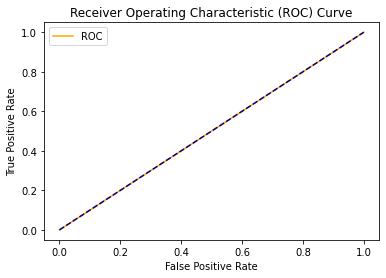

In [11]:
# building model
# SVM
from sklearn.svm import SVC
svm = SVC(gamma=10,C=1,degree=0,kernel='rbf')
svm.fit(features_train_scaled, labels_train)
svm_pred = svm.predict(features_test_scaled)
accuracy, precision, recall, f1, auroc = display_metrics(labels_test, svm_pred)
plot_roc_curve(labels_test, svm_pred)